In [1]:
import random
import os
import operator
import gym
from skimage import io, color, transform
import numpy as np
from keras.layers import Dropout
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import TensorBoard
from collections import deque
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
callbacks = []
class Agent:
        #
    def __init__(self,action_size,epsilon=1.0,experience_replay_capacity=1000,minibatch_size=32,learning_rate=0.01,gamma=0.95,preprocess_image_dim=84):
        self.action_size = action_size
        self.epsilon = epsilon
        self.experience_replay_capacity = experience_replay_capacity
        self.minibatch_size = minibatch_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.preprocess_image_dim = preprocess_image_dim

        self.memory = []
        self.ere_counter = 0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98
        self.model = self.create_model()


    def create_model(self):
        model = Sequential()
        model.add(Dense(32, input_shape=(1,PREPROCESS_IMAGE_DIM,PREPROCESS_IMAGE_DIM), activation='tanh'))
         
        model.add(Conv2D(32, (5,5), strides=(1,1), padding='same', data_format='channels_first', activation='tanh', use_bias=True, bias_initializer='zeros'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None))

        model.add(Conv2D(64, (5,5), strides=(1,1), padding='same', data_format=None, activation='relu', use_bias=True, bias_initializer='zeros'))
        
        model.add(Dense(24, activation='tanh'))
        model.add(Dense(self.action_size, activation='tanh'))
        model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = self.learning_rate))
       
        tensorboard_dir = "/home/master/2017-dlai-team6/tensorboard/orig1"
        if True:
        	callbacks.append(TensorBoard(
				log_dir=tensorboard_dir,
				histogram_freq=0,
				write_graph=True,
				write_images=True))

        return model


    def append_experience_replay_example(self, experience_replay_example):
        """
        Add an experience replay example to our agent's replay memory. If
        memory is full, overwrite previous examples, starting with the oldest
        """
        if (self.ere_counter >= self.experience_replay_capacity):
            self.ere_counter = 0
            self.memory[self.ere_counter] = experience_replay_example
        else:
            self.memory.append(experience_replay_example)
        self.ere_counter += 1


    def preprocess_observation(self, observation, prediction=False):
        """
        Helper function for preprocessing an observation for consumption by our
        deep learning network
        """
        #print(observation.shape)
        grayscale_observation = color.rgb2gray(observation)
        #print(grayscale_observation.shape) #(210,160)
        resized_observation = transform.resize(grayscale_observation, (1, self.preprocess_image_dim, self.preprocess_image_dim)).astype('float32')
        if prediction:
            resized_observation = np.expand_dims(resized_observation, 0)
        #print(resized_observation.shape) (1,84,84)
        return resized_observation

    def take_action(self, observation):
        """
        Given an observation, the model attempts to take an action
        according to its q-function approximation
        """
        observation = np.array(observation)
        observation = np.reshape(observation, [1,1,self.preprocess_image_dim,self.preprocess_image_dim])

        #print(observation.shape) (1,84,84)
        if (np.random.rand() <= self.epsilon):
            action = random.randrange(self.action_size)
            return action
        act_values = self.model.predict(observation) # Forward Propagation
        action = np.argmax(act_values[0])
        return action

    def learn(self):
        """
        Allow the model to collect examples from its experience replay memory
        and learn from them
        """
        minibatch = random.sample(self.memory, self.minibatch_size)
        for obs, action, reward, next_obs, done in minibatch:
            obs = np.reshape(np.array(obs),[1,1,self.preprocess_image_dim,self.preprocess_image_dim])
            next_obs = np.reshape(np.array(next_obs),[1,1,self.preprocess_image_dim,self.preprocess_image_dim])
            target = reward
            if not done:
                target = reward + self.gamma*np.amax(self.model.predict(next_obs)[0])
            target_f = self.model.predict(obs)
            target_f[0][action] = target
            self.model.fit(obs, target_f, epochs=1, verbose=0,callbacks=callbacks)
        if (self.epsilon > self.epsilon_min):
            self.epsilon *= self.epsilon_decay

In [10]:
#####
# Hyperparameters
#####

GAME_TYPE = 'MsPacman-v0'

#environment parameters
NUM_EPISODES = 180
MAX_TIMESTEPS = 5
FRAME_SKIP = 2
PHI_LENGTH = 4

#agent parameters
NAIVE_RANDOM = False
EPSILON = 1
GAMMA = 0.95
EXPERIENCE_REPLAY_CAPACITY = 5000
MINIBATCH_SIZE = 32
LEARNING_RATE = 0.01
PREPROCESS_IMAGE_DIM = 120
SCORE_LIST = []



def run_simulation():
    """
    Entry-point for running Ms. Pac-man simulation
    """

    ENV = gym.make(GAME_TYPE)
    ACTION_SIZE = ENV.action_space.n
    DONE = False

    #print game parameters
    print ("~~~Environment Parameters~~~")
    print ("Num episodes: %s" % NUM_EPISODES)
    print ("Max timesteps: %s" % MAX_TIMESTEPS)
    print ("Action space: %s" % ACTION_SIZE)
    print ("~~~Agent Parameters~~~")
    print ("Naive Random: %s \n" % NAIVE_RANDOM)
    print ("Epsilon: %s" % EPSILON)
    print ("Experience Replay Capacity: %s" % EXPERIENCE_REPLAY_CAPACITY)
    print ("Minibatch Size: %s" % MINIBATCH_SIZE)
    print ("Learning Rate: %s" % LEARNING_RATE)

    #initialize agent
    agent = Agent(action_size = ACTION_SIZE,epsilon=EPSILON,
                experience_replay_capacity=EXPERIENCE_REPLAY_CAPACITY,
                minibatch_size=MINIBATCH_SIZE,
                learning_rate=LEARNING_RATE,gamma = GAMMA,preprocess_image_dim=PREPROCESS_IMAGE_DIM)

    #initialize auxiliary data structures
    S_LIST = [] # Stores PHI_LENGTH frames at a time
    TOT_FRAMES = 0  # Counter of frames covered till now

    for i_episode in range(NUM_EPISODES):
        obs = ENV.reset()
        EPISODE_REWARD = 0
        time = 0
        obsProc = agent.preprocess_observation(obs)
        prev_lives = 3
        while True:
            #ENV.render()
            OBS = agent.preprocess_observation(obs)
            #ensure that S_LIST is populated with PHI_LENGTH frames
            
            if TOT_FRAMES < PHI_LENGTH:
                S_LIST.append(agent.preprocess_observation(OBS))
                TOT_FRAMES += 1
                continue
            
            X = np.array(S_LIST)
            #print(X.shape) #(4,1,84,84)

            # call take_action
            ACTION = agent.take_action(obsProc)
            #print(ACTION)

            newObs, REWARD, DONE, INFO = ENV.step(ACTION) # NEXT_OBS is a numpy.ndarray of shape(210,160,3)
            
            if REWARD != 0 and REWARD != 10:
            	print(REWARD, "Some")
            if REWARD == 200:
                REWARD = 0

            if REWARD == 50:
                REWARD = 100

            LIVES = INFO.get('ale.lives')
            if prev_lives>LIVES:
            	prev_lives = LIVES
            	REWARD = REWARD - 10
            	pass
            # Calculation of Reward
            REWARD = REWARD * 2
            
           	#if DONE:
           	#	print("Loooser")

            #if (time%50==0):
                #print(REWARD)

            #print((REWARD), type(ENV))

            newObsProc = agent.preprocess_observation(newObs) # shape(1,84,84)

            EREG = [obsProc, ACTION, REWARD, newObsProc, DONE]

            agent.append_experience_replay_example(EREG)

            obsProc = newObsProc
            if DONE:
                print("episode:{}/{}, score: {}, e = {}".format(i_episode, NUM_EPISODES, EPISODE_REWARD/2, agent.epsilon))
                break

            #update state list with next observation
            """
            S_LIST.append(agent.preprocess_observation(OBS))
            S_LIST.pop(0)
            """
            EPISODE_REWARD += REWARD
            time += 1

        if (i_episode%5==0):
            SCORE_LIST.append(EPISODE_REWARD)
        if (len(agent.memory)>agent.minibatch_size):
            agent.learn()

def plot_rewards(score_list, episode_num):
    episode_num = [x for x in range(0,episode_num,5)]
    plt.plot(episode_num, score_list)
    plt.show()

~~~Environment Parameters~~~
Num episodes: 180
Max timesteps: 5
Action space: 9
~~~Agent Parameters~~~
Naive Random: False 

Epsilon: 1
Experience Replay Capacity: 5000
Minibatch Size: 32
Learning Rate: 0.01


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


episode:0/180, score: 190.0, e = 1
episode:1/180, score: 190.0, e = 0.98
episode:2/180, score: 110.0, e = 0.9603999999999999
episode:3/180, score: 220.0, e = 0.9411919999999999
episode:4/180, score: 120.0, e = 0.9223681599999999
episode:5/180, score: 250.0, e = 0.9039207967999998
episode:6/180, score: 210.0, e = 0.8858423808639998
episode:7/180, score: 190.0, e = 0.8681255332467198
episode:8/180, score: 230.0, e = 0.8507630225817854
episode:9/180, score: 220.0, e = 0.8337477621301497
episode:10/180, score: 240.0, e = 0.8170728068875467
episode:11/180, score: 170.0, e = 0.8007313507497957
episode:12/180, score: 190.0, e = 0.7847167237347998
episode:13/180, score: 110.0, e = 0.7690223892601038
episode:14/180, score: 220.0, e = 0.7536419414749017
episode:15/180, score: 160.0, e = 0.7385691026454037
episode:16/180, score: 260.0, e = 0.7237977205924956
episode:17/180, score: 250.0, e = 0.7093217661806457
50.0 Some
200.0 Some
episode:18/180, score: 490.0, e = 0.6951353308570327
episode:19/18

50.0 Some
episode:147/180, score: 410.0, e = 0.05131367589555342
episode:148/180, score: 40.0, e = 0.05028740237764235
episode:149/180, score: 310.0, e = 0.0492816543300895
episode:150/180, score: 150.0, e = 0.04829602124348771
episode:151/180, score: 160.0, e = 0.04733010081861796
episode:152/180, score: 180.0, e = 0.0463834988022456
episode:153/180, score: 100.0, e = 0.04545582882620069
50.0 Some
episode:154/180, score: 420.0, e = 0.04454671224967667
episode:155/180, score: 40.0, e = 0.043655778004683135
50.0 Some
episode:156/180, score: 340.0, e = 0.04278266244458947
episode:157/180, score: 180.0, e = 0.04192700919569768
episode:158/180, score: 230.0, e = 0.04108846901178373
episode:159/180, score: 130.0, e = 0.04026669963154805
episode:160/180, score: 220.0, e = 0.03946136563891709
episode:161/180, score: 100.0, e = 0.03867213832613875
episode:162/180, score: 90.0, e = 0.037898695559615975
episode:163/180, score: 40.0, e = 0.03714072164842366
episode:164/180, score: 290.0, e = 0.03

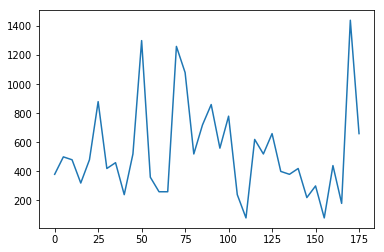

In [11]:
run_simulation()
plot_rewards(SCORE_LIST, NUM_EPISODES)